In [1]:
import numpy as np
import pandas as pd
from debugpy.launcher import channel
from scipy.signal import firwin, lfilter
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/Users/admin/PycharmProjects/ET_eksploracja/hyperscanning-signal-analysis')
%matplotlib inline


In [2]:
def process_time(ch_pos_df_0, cg_pos_df_0, ch_pupil_df_0, cg_pupil_df_0,ch_pupil_df_1, cg_pupil_df_1, ch_pupil_df_2, cg_pupil_df_2, Fs=1000):
    '''
    :param ch_pos_df: child gaze_positions_on_surface_Surface dataframe
    :param cg_pos_df: caregiver gaze_positions_on_surface_Surface dataframe
    :param ch_pupil_df: child pupil_positions dataframe
    :param cg_pos_df: caregiver pupil_positions dataframe
    :param Fs: sampling frequency
    :return: common time
    '''
    #pupli 000
    min_ch_pupil_0 = min(ch_pupil_df_0['pupil_timestamp'])
    max_ch_pupil_0 = max(ch_pupil_df_0['pupil_timestamp'])
    min_cg_pupil_0= min(cg_pupil_df_0['pupil_timestamp'])
    max_cg_pupil_0 = max(cg_pupil_df_0['pupil_timestamp'])
    #pupil 001
    min_ch_pupil_1 = min(ch_pupil_df_1['pupil_timestamp'])
    max_ch_pupil_1 = max(ch_pupil_df_1['pupil_timestamp'])
    min_cg_pupil_1 = min(cg_pupil_df_1['pupil_timestamp'])
    max_cg_pupil_1 = max(cg_pupil_df_1['pupil_timestamp'])
    #pupil 002
    min_ch_pupil_2 = min(ch_pupil_df_2['pupil_timestamp'])
    max_ch_pupil_2 = max(ch_pupil_df_2['pupil_timestamp'])
    min_cg_pupil_2 = min(cg_pupil_df_2['pupil_timestamp'])
    max_cg_pupil_2 = max(cg_pupil_df_2['pupil_timestamp'])
    #pos 000
    min_cg_pos = min(cg_pos_df_0['gaze_timestamp'])
    min_ch_pos = min(ch_pos_df_0['gaze_timestamp'])
    max_ch_pos = max(ch_pos_df_0['gaze_timestamp'])
    max_cg_pos = max(cg_pos_df_0['gaze_timestamp'])
    
    
    min_t = min(min_cg_pos, min_ch_pos, min_cg_pupil_0, min_ch_pupil_0, min_cg_pupil_1, min_ch_pupil_1, min_cg_pupil_2, min_ch_pupil_2)
    max_t = max(max_cg_pos, max_ch_pos, max_cg_pupil_0, max_ch_pupil_0, max_cg_pupil_1, max_ch_pupil_1, max_cg_pupil_2, max_ch_pupil_2)
    print("min", min_t)
    print("max", max_t)
    t = np.arange(min_t, max_t, 1 / Fs)
    return t

In [3]:
def process_pos(pos_df, time):
    pos_df = pos_df[pos_df['on_surf'] != False]
    x_result = pos_df.groupby('gaze_timestamp')['x_norm'].mean().reset_index()
    y_result = pos_df.groupby('gaze_timestamp')['y_norm'].mean().reset_index()

    x_interp = np.interp(time, x_result['gaze_timestamp'], x_result['x_norm'])
    y_interp = np.interp(time, y_result['gaze_timestamp'], y_result['y_norm'])

    return x_interp, y_interp


In [4]:
def process_pupil(pupil_df, df, who, model_confidence=0.9, median_size=10, order=351, cutoff=1, Fs=1000, plot_flag=False):
    '''
    :param pupil_df: pupil positions dataframe
    :param time: common time for all signals
    :param model_confidence: confidence level for 3D pupil model
    :param median_size: size of median filter
    :param order: order of low pass filter 
    :param cutoff: frequency cutoff for low pass filter
    :param Fs: sampling frequency
    :param plot_flag: debug plot
    :return: array of filtered pupil diameters
    '''
    
    filtr_3d = pupil_df[pupil_df['model_confidence'] > model_confidence]
    filtr_3d = filtr_3d.copy()
    minimum =  min(filtr_3d['pupil_timestamp'])
    maximum = max(filtr_3d['pupil_timestamp'])
    mask = (df['time'] >= minimum) & (df['time'] <= maximum)
    filtr_3d['diameter3d_median'] = ndimage.median_filter(filtr_3d['diameter_3d'], size=median_size)
    diameter3d_interp = np.interp(df['time'], filtr_3d['pupil_timestamp'], filtr_3d['diameter3d_median'])
    b = firwin(order, cutoff=cutoff, fs=Fs)
    # Remember the first sample
    miu = diameter3d_interp[0]
    diameter3d_interp_filtred = lfilter(b, a=[1], x=diameter3d_interp-miu)
    delay = (len(b) - 1) // 2

    # Delay correction
    diameter3d_interp_filtred_aligned = np.roll(diameter3d_interp_filtred, -delay)

    # Fix last samples 
    diameter3d_interp_filtred_aligned[-delay:] = np.nan
    # Fix the level
    diameter3d_interp_filtred_aligned += miu
    # Debug plot
    if plot_flag:
        plt.figure()
        plt.plot(pupil_df['pupil_timestamp'], pupil_df['diameter_3d'])
        plt.plot(df['time'], diameter3d_interp_filtred_aligned)
        plt.show()
    col_name = f'{who}_diameter3d'
    if col_name not in df.columns:
        df[col_name] = None
        
    df.loc[mask, col_name] = diameter3d_interp_filtred_aligned[mask]
    return df[col_name]

In [5]:
def process_event(annotations, df, event_name=None):
    annotations['type'] = annotations['label'].str.split('_').str[0]
    annotations['event'] = annotations['label'].str.split('_').str[1]

    starts = annotations[annotations['type'] == 'start'][['event', 'timestamp']]
    stops  = annotations[annotations['type'] == 'stop'][['event', 'timestamp']]

    starts = starts.rename(columns={'timestamp': 't_start'})
    stops  = stops.rename(columns={'timestamp': 't_stop'})
    if 'event' not in df.columns:
        df['event'] = None
    intervals = starts.merge(stops, on='event')
    for _, row in intervals.iterrows():
        mask = (df['time'] >= row['t_start']) & (df['time'] <= row['t_stop'])
        if event_name is None:
            df.loc[mask, 'event'] = row['event']
        else:
            df.loc[mask, 'event'] = event_name
    return df['event']   
    

In [6]:
def process_blinks(blinks,df,who):
    cols = ['start_timestamp','end_timestamp','confidence']
    blinks = blinks[cols]
    col_name = f'{who}_blinks'
    if col_name not in df.columns:
        df[col_name] = 0.0
        
    for _, row in blinks.iterrows():
        mask = (df['time'] >= row['start_timestamp']) & (df['time'] <= row['end_timestamp'])
        df.loc[mask, col_name] = row['confidence']
    return df[col_name] 

In [7]:
def reset_time_to_first_event(df):
    df = df.loc[df['event'].notnull()]
    first = df['time'].iloc[0]
    df['time'] = df['time'] - first
    return df

In [8]:
Fs = 1024
order = 351

ET data from watching movies

In [9]:
ch_pos_df_0 = pd.read_csv('../data/et_data/000/ch_gaze_positions_on_surface_Surface 1.csv')
cg_pos_df_0 = pd.read_csv('../data/et_data/000/cg_gaze_positions_on_surface_Surface 1.csv')
ch_pupil_df_0 = pd.read_csv('../data/et_data/000/ch_pupil_positions.csv')
cg_pupil_df_0 = pd.read_csv('../data/et_data/000/cg_pupil_positions.csv')
annotations_0 = pd.read_csv('../data/et_data/000/annotations.csv')
cg_blinks_0 = pd.read_csv('../data/et_data/000/cg_blinks.csv')
ch_blinks_0 = pd.read_csv('../data/et_data/000/ch_blinks.csv')

ET data from talk 1

In [10]:
ch_pupil_df_1 = pd.read_csv('../data/et_data/001/ch_pupil_positions.csv')
cg_pupil_df_1 = pd.read_csv('../data/et_data/001/cg_pupil_positions.csv')
annotations_1 = pd.read_csv('../data/et_data/001/annotations.csv')
cg_blinks_1 = pd.read_csv('../data/et_data/001/cg_blinks.csv')
ch_blinks_1 = pd.read_csv('../data/et_data/001/ch_blinks.csv')

ET data from talk 2

In [11]:
ch_pupil_df_2 = pd.read_csv('../data/et_data/002/ch_pupil_positions.csv')
cg_pupil_df_2 = pd.read_csv('../data/et_data/002/cg_pupil_positions.csv')
annotations_2 = pd.read_csv('../data/et_data/002/annotations.csv')
cg_blinks_2 = pd.read_csv('../data/et_data/002/cg_blinks.csv')
ch_blinks_2 = pd.read_csv('../data/et_data/002/ch_blinks.csv')

In [12]:
df = pd.DataFrame()

In [13]:
df['time'] = process_time(ch_pos_df_0, cg_pos_df_0, ch_pupil_df_0, cg_pupil_df_0, ch_pupil_df_1, cg_pupil_df_1, ch_pupil_df_2, cg_pupil_df_2, Fs=Fs)

min 347.531023743903
max 1056.456152707318


In [14]:
df['ch_x_interp'],df['ch_y_interp'] = process_pos(ch_pos_df_0, df['time'])

In [15]:
df['cg_x_interp'],df['cg_y_interp'] = process_pos(cg_pos_df_0, df['time'])

In [16]:
df['time'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 725940 entries, 0 to 725939
Series name: time
Non-Null Count   Dtype  
--------------   -----  
725940 non-null  float64
dtypes: float64(1)
memory usage: 5.5 MB


In [17]:
df['ch_diameter3d'] = process_pupil(ch_pupil_df_0, df,'ch')
df['ch_diameter3d'] = process_pupil(ch_pupil_df_1, df,'ch')
df['ch_diameter3d'] = process_pupil(ch_pupil_df_2, df,'ch')

In [18]:
df['cg_diameter3d'] = process_pupil(cg_pupil_df_0, df,'cg')
df['cg_diameter3d'] = process_pupil(cg_pupil_df_1, df,'cg')
df['cg_diameter3d'] = process_pupil(cg_pupil_df_2, df,'cg')

In [19]:
#df['dist'] = np.sqrt((df['ch_x_interp'] - df['cg_x_interp'])**2 + (df['ch_y_interp'] - df['cg_y_interp'])**2)

In [20]:
df['event'] = process_event(annotations_0, df)
df['event'] = process_event(annotations_1, df, 'talk1')
df['event'] = process_event(annotations_2, df, 'talk2')

In [21]:
df['cg_blinks'] = process_blinks(cg_blinks_0, df,'cg')
df['cg_blinks'] = process_blinks(cg_blinks_1, df,'cg')
df['cg_blinks'] = process_blinks(cg_blinks_2, df,'cg')

In [22]:
df['ch_blinks'] = process_blinks(ch_blinks_0, df,'ch')
df['ch_blinks'] = process_blinks(ch_blinks_1, df,'ch')
df['ch_blinks'] = process_blinks(ch_blinks_2, df,'ch')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725940 entries, 0 to 725939
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           725940 non-null  float64
 1   ch_x_interp    725940 non-null  float64
 2   ch_y_interp    725940 non-null  float64
 3   cg_x_interp    725940 non-null  float64
 4   cg_y_interp    725940 non-null  float64
 5   ch_diameter3d  664326 non-null  object 
 6   cg_diameter3d  665043 non-null  object 
 7   event          551862 non-null  object 
 8   cg_blinks      725940 non-null  float64
 9   ch_blinks      725940 non-null  float64
dtypes: float64(7), object(3)
memory usage: 55.4+ MB


In [24]:
df['time'].max()

1056.455828431403

In [25]:
df['time'].min()

347.531023743903

In [26]:
df['event'].unique()

array([None, 'm1', 'm2', 'm3', 'talk1', 'talk2'], dtype=object)

In [27]:
df['ch_blinks'].value_counts()

ch_blinks
0.000000    592492
0.007798     53356
0.103591     15857
0.079602     15599
0.037297      9436
0.060405      7150
0.127822      5751
0.110733      4381
0.139976      3544
0.136021      3475
0.155218      1834
0.098116      1393
0.152940      1348
0.122941      1151
0.207888      1132
0.230256      1037
0.094307       965
0.124289       853
0.262403       835
0.247689       633
0.314137       401
0.635317       309
0.438765       292
0.546913       279
0.684505       275
0.699984       274
0.380301       256
0.542155       245
0.543341       240
0.664432       235
0.671866       230
0.475826       221
0.492479       195
0.311503       145
0.322449       121
Name: count, dtype: int64

In [28]:
df['event'].unique()

array([None, 'm1', 'm2', 'm3', 'talk1', 'talk2'], dtype=object)

In [29]:
!pwd

/Users/admin/PycharmProjects/ET_eksploracja/hyperscanning-signal-analysis


In [30]:
from src import dataloader
# creates a DataLoader class object that creates a structure described in the docs folder (data_structure_spec.md) from raw data
# data = DataLoader(, )
multimodal_data = dataloader.load_eeg_data("W_010", "../data/eeg_data/", False)
dataloader.save_to_file(multimodal_data, "../data/out")


Detected events: [{'name': 'Brave', 'start': 419.9169921875, 'duration': 59.33203125}, {'name': 'Peppa', 'start': 489.482421875, 'duration': 59.630859375}, {'name': 'Incredibles', 'start': 559.3466796875, 'duration': 59.212890625}, {'name': 'Talk_1', 'start': 696.431640625, 'duration': 181.0556640625}, {'name': 'Talk_2'}]


In [31]:
channel_mapping = multimodal_data.eeg_channel_mapping
x = multimodal_data.eeg_data[channel_mapping['Fp1'],:]
d = multimodal_data.diode

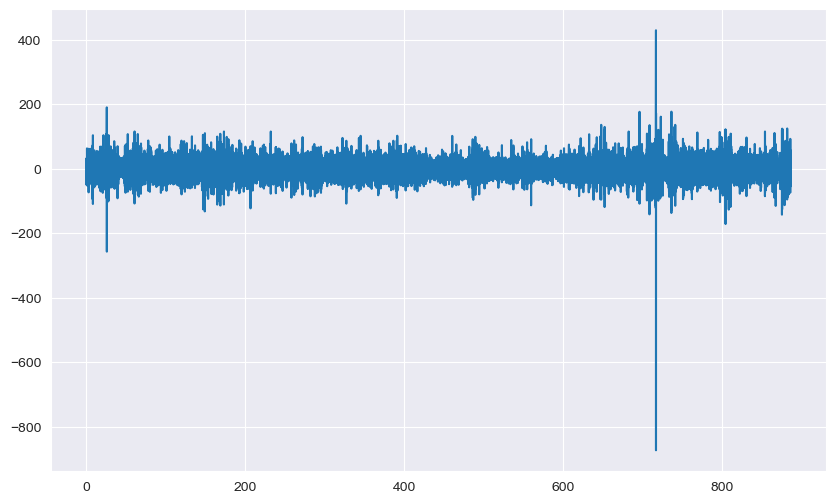

In [32]:
time = np.arange(0, len(x)/multimodal_data.eeg_fs, 1/multimodal_data.eeg_fs)
plt.figure(figsize=(10,6))
plt.plot(time, x)
plt.show()

In [33]:
df = reset_time_to_first_event(df)

/var/folders/26/8g479t651wg0063m05yzr47w0000gn/T/ipykernel_42196/2783740618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df['time'] - first


In [34]:
df.loc[df['event'] == 'talk1', 'time']

288567    276.781250
288568    276.782227
288569    276.783203
288570    276.784180
288571    276.785156
             ...    
472896    456.790039
472897    456.791016
472898    456.791992
472899    456.792969
472900    456.793945
Name: time, Length: 184334, dtype: float64

In [35]:
multimodal_data.events

[{'name': 'Brave', 'start': 419.9169921875, 'duration': 59.33203125},
 {'name': 'Peppa', 'start': 489.482421875, 'duration': 59.630859375},
 {'name': 'Incredibles', 'start': 559.3466796875, 'duration': 59.212890625},
 {'name': 'Talk_1', 'start': 696.431640625, 'duration': 181.0556640625},
 {'name': 'Talk_2'}]

In [36]:
minimum = min(t['start'] for t in multimodal_data.events if 'start' in t)
minimum

419.9169921875

In [37]:
minimum = int(minimum * multimodal_data.eeg_fs)

In [42]:
df['time']

5143        0.000000
5144        0.000977
5145        0.001953
5146        0.002930
5147        0.003906
             ...    
721874    699.932617
721875    699.933594
721876    699.934570
721877    699.935547
721878    699.936523
Name: time, Length: 551862, dtype: float64

KeyError: 'time'

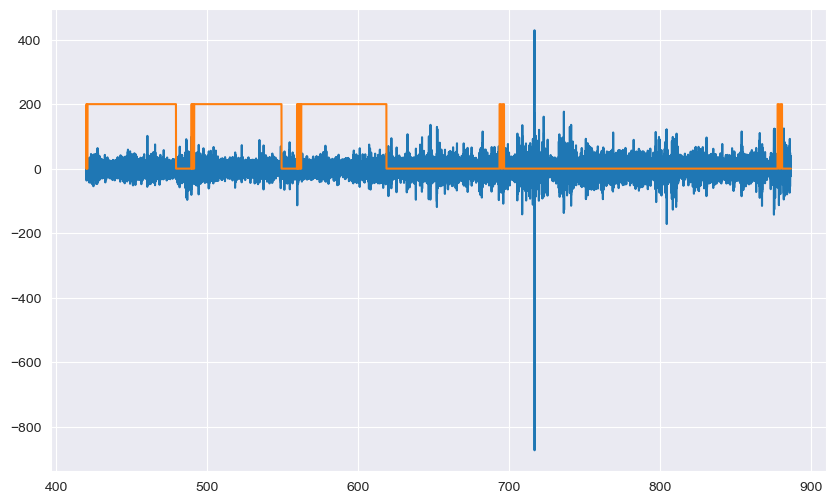

In [47]:
time = np.arange(0, len(x)/multimodal_data.eeg_fs, 1/multimodal_data.eeg_fs)
plt.figure(figsize=(10,6))
plt.plot(time[minimum:], x[minimum:])
plt.plot(time[minimum:], d[minimum:]*200)
plt.plot(time[minimum:], df.loc[df['event'] == 'talk1'])

plt.show()

ValueError: ('Lengths must match to compare', (184334,), (477621,))